In [2]:
import MDAnalysis as mda 
import numpy as np
import os 
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt
import nglview as ngl
from MDAnalysis.analysis.rdf import InterRDF


In [32]:
#######################################################################
#pi stacking analysis functions - micaela matta
######################################################################

import numpy as np
import MDAnalysis as mda
from MDAnalysis.lib.distances import *
from MDAnalysis.analysis.rdf import InterRDF
import networkx as nx
import itertools

def find_all_rings(u):
    # Returns itic donor and acceptors rings
    # Handle atoms as Graph
    g = nx.Graph()
    g.add_edges_from(u.bonds.to_indices())
    
    # cycle_basis gives all rings
    # but a fused ring
    cycles = nx.cycle_basis(g)
    
    # all atoms that are part of a ring
    ring_members = set(itertools.chain(*cycles))
    ring_ag = u.atoms[list(ring_members)]
    
    # make a new graph, this time of all rings
    g = nx.Graph()
    for cycle in cycles:
        g.add_edges_from([(cycle[i], cycle[i+1]) for i in range(len(cycle)-1)])
        g.add_edge(cycle[-1], cycle[0])
    
    # Can then separate the connected parts of the graph
    # Fixed: use connected_components instead of connected_component_subgraphs
    chunks = [g.subgraph(c) for c in nx.connected_components(g)]
    
    # locate donors as the biggest fused rings
    # Fixed: accessing nodes properly based on NetworkX version
    rings = [u.atoms[list(r.nodes())] for r in chunks if len(r) > 4]
    
    return rings

def chunk_position(ring):
    return ring.center_of_geometry()


def unit_vector(ag):
    # for a 2 member ag, return the unit vector
    if len(ag) != 2:
        raise ValueError("disagio")
    vec = ag[1].position - ag[0].position
    return vec / np.sqrt((vec * vec).sum())

def normal_vector(ring):
    ag1 = ring[[0, 2]]
    ag2 = ring[[1, 3]]

    v1 = unit_vector(ag1)
    v2 = unit_vector(ag2)

    normal = np.cross(v1, v2)

    return normal / np.linalg.norm(normal)

def split_bigrings(fusedring):
    #returns list of lists with atom indexes -one per ring
    g = nx.Graph()
    g.add_edges_from(fusedring.bonds.to_indices())
    fusedcycles = nx.cycle_basis(g)

    return fusedcycles

def n_piint(u, rings_perchain):
    """Calculate the number of pi-pi interactions between rings in the universe 
    Returns:
    npi = number of contacts
    ang = angle between the normals of the rings
    dst = distance between the centers of the rings
    avgpi = average shortest distance between the atoms of the rings"""

#def n_piint(u, rings_perchain,pdbname):
    #ALL INTERACTIONS
#   u.add_TopologyAttr('tempfactors')
    npi=[]
    dst=[]
    ang=[]
    avgpi=[]
    rings = find_all_rings(u)
   #poly=u.atoms.select_atoms('not resname WAT')
   # ts=u.trajectory[-1]
   #with mda.Writer(pdbname+'.pdb', multiframe=False, bonds=None, n_atoms=poly.n_atoms) as PDB:
    for ts in u.trajectory[-5000::10]:
        rings_pos= np.array([chunk_position(r) for r in rings if len(r)>4])
        # distance selection
        pairs, dist= capped_distance(rings_pos,rings_pos, max_cutoff=6,min_cutoff=3., box=u.dimensions)
        
        #exclude self contributions because yeah
        ringwise = pairs // rings_perchain
        mask=np.logical_not(ringwise[:,0] == ringwise[:, 1])
        dist=dist[mask]
        pairs=pairs[mask]
        
        dst.append(dist)
        
        i=pairs[:,0]
        j=pairs[:,1]
 
        vecs = np.array([normal_vector(r) for r in rings])
 
        # angle selection
        angle = (vecs[i] * vecs[j]).sum(axis=1) ** 2
        ang.append(angle)  
 
        thresh = np.cos(np.deg2rad(30)) ** 2
        winners = angle > thresh
 
        i = i[winners]
        j = j[winners]
 
        # check if at least one of the atom-atom distance in the ring is between 3.5 and 4 A
        # lazy way to account for staggered interactions
        # the alternative would be too expensive - project the coordinate of each ring vertex
        # and check if it falls inside the polygon/polyhedron defined by the other ring. ugh
        ncontacts = 0
        for x,y in zip(i,j):
            ix , d = capped_distance(rings[x].atoms.positions, rings[y].atoms.positions,
                            max_cutoff=4.4, #this 
                            min_cutoff=3,
                            box=u.dimensions,
                            return_distances=True)
            if len(ix):
                ncontacts += 1
                avgpi.append(np.min(d))
            #win.append(len(ix))
    #           rings[x].tempfactors = 6
    #           rings[y].tempfactors = 6
        npi.append(ncontacts)
 
        # Save rings and positions
    #   PDB.write(poly)
        #returns the NUMBER of CONTACTS
    return np.array(npi), np.array(ang), np.array(dst),  np.array(avgpi)


def rdf_rings(u, name):
    """Calculate the RDF of all rings in the universe and write it to a file"""
    rings = find_all_rings(u)
    group = RingGroup(rings)
    rdf = InterRDF(g1 = group, g2 = group, range = (0,15), 
                                           nbins = 300, 
                                           start = -1500,
   #                                        step  = 10, 
                                           exclusion_block=(48,48)) #this is the number of ring interactions to exclude
    rdf.run()
    rdf_saved = np.zeros((len(rdf.bins),2))
    rdf_saved[:,0] = rdf.bins
    rdf_saved[:,1] = rdf.rdf
    np.save(name, rdf_saved)

class RingGroup(object):
    def __init__(self, groups):
        self._groups = groups

    def __len__(self):
        return len(self._groups)

    @property
    def positions(self):
        return np.array([g.center_of_geometry() for g in self._groups], dtype=np.float32)

    @property
    def universe(self):
        return self._groups[0].universe

In [4]:
u = mda.Universe('molecule1/pdb import files/output_labeled.pdb', 'molecule1/dcd files/trajectory_prodholdtrp1_dcd.dcd', guess_bonds = True)
u2 = mda.Universe('molecule2/pdb import files/output_labeled.pdb', 'molecule2/dcd files/trajectory_prodhold2trp1_dcd.dcd', guess_bonds= True)
u.atoms.names=u.atoms.types
u2.atoms.names=u2.atoms.types

/Users/darv/micromamba/envs/melanin/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [24]:
sc_o = u.atoms.select_atoms('resname SC1 and type O')
sc_o2 = u.atoms.select_atoms('resname SC2 and type O')
allside = sc_o + sc_o2

sc_o_2 = u2.atoms.select_atoms('resname SC1 and type O')
sc_o2_2 = u2.atoms.select_atoms('resname SC2 and type O')
allside2 = sc_o_2 + sc_o2_2



In [25]:
side1 = u.select_atoms('id 15:25') + u.select_atoms('id 77:91')
side1oxy = side1.select_atoms('type O')
#ngl.show_mdanalysis(side1oxy)

In [26]:
side_2 = u2.select_atoms('id 15:40') + u2.select_atoms('id 107:141')
side2oxy = side_2.select_atoms('type O')
#ngl.show_mdanalysis(side2oxy)

In [27]:
bb = u.atoms.select_atoms('resname BAC and not type H')
bb_2 = u2.atoms.select_atoms('resname BAC and not type H')

backbone = bb.select_atoms('id 0:70 and not id 1 and not id 2 and not id 10 and not id 9 and not id 11 and not id 57 and not id 56 and not id 60 and not id 59') 
backbone2 = bb_2.select_atoms('id 0:191 and not id 10 and not id 9 and not id 2 and not id 1 and not id 90 and not id 89 and not id 87 and not id 86') 
ngl.show_mdanalysis(backbone2)

NGLWidget(max_frame=999)

In [28]:

backbone = bb.select_atoms('id 0:121')
backbone2 = bb_2.select_atoms('id 0:191')
backboneuni = u.select_atoms('resname BAC and not type H')
backboneuni2 = u2.select_atoms('resname BAC and not type H')
bbuni_real = backboneuni.select_atoms('not id 0:121')
bbuni_real2 = backboneuni.select_atoms('not id 0:191')
ngl.show_mdanalysis(backboneuni)



NGLWidget(max_frame=999)

In [33]:
find_all_rings(u)

[<AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 5 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 <AtomGroup with 9 atoms>,
 

In [34]:
backbone_rings_universe = find_all_rings(u)
backbone_rings_universe2 = find_all_rings(u2)

In [35]:
#since universe works do the following 

""" import universe with only selected rings, conduct RDF with specified atom ring  """

donoru = mda.Universe('molecule1/ring universe/eum.pdb', 'molecule1/ring universe/eum.dcd', guess_bonds= True)
acceptoru = mda.Universe('molecule1/ring universe/oth.pdb', 'molecule1/ring universe/oth.dcd', guess_bonds= True)

donoru2 = mda.Universe ('molecule2/ring universe/eum.pdb', 'molecule2/ring universe/eum.dcd', guess_bonds=True)
acceptoru2 = mda.Universe('molecule2/ring universe/oth.pdb', 'molecule2/ring universe/oth.dcd', guess_bonds=True)

/Users/darv/micromamba/envs/melanin/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [36]:
""" acceptor imports """

acceptoronly = mda.Universe('molecule1/ring universe/singleoth.pdb','molecule1/ring universe/singleoth.dcd',guess_bonds= True)
acceptorexcept = mda.Universe('molecule1/ring universe/notsingleoth.pdb','molecule1/ring universe/notsingleoth.dcd', guess_bonds=True)

acceptoronly2 = mda.Universe('molecule2/ring universe/singleoth.pdb','molecule2/ring universe/singleoth.dcd',guess_bonds= True)
acceptorexcept2 = mda.Universe('molecule2/ring universe/notsingleoth.pdb','molecule2/ring universe/notsingleoth.dcd', guess_bonds=True)

In [37]:
""" donor imports """

donoronly = mda.Universe('molecule1/ring universe/singleeum.pdb','molecule1/ring universe/singleeum.dcd',guess_bonds= True)
donorexcept = mda.Universe('molecule1/ring universe/notsingleeum.pdb','molecule1/ring universe/notsingleeum.dcd', guess_bonds=True)

donoronly2 = mda.Universe('molecule2/ring universe/singleeum.pdb','molecule2/ring universe/singleeum.dcd',guess_bonds= True)
donorexcept2 = mda.Universe('molecule2/ring universe/notsingleeum.pdb','molecule2/ring universe/notsingleeum.dcd', guess_bonds=True)


In [38]:
ngl.show_mdanalysis(donoronly2)

NGLWidget(max_frame=1000)

In [39]:
donorsingle = donoru.select_atoms('id 0:8') + donoru.select_atoms('id 18')
#ngl.show_mdanalysis(donorsingle)
acceptorsingle = acceptoru.select_atoms('id 0:9')
#ngl.show_mdanalysis(acceptorsingle)

In [40]:
donorsingle2 = donoru2.select_atoms('id 0:8') + donoru2.select_atoms('id 18')
#ngl.show_mdanalysis(donorsingle)
acceptorsingle2 = acceptoru2.select_atoms('id 0:9')
#ngl.show_mdanalysis(acceptorsingle)

In [41]:
def rdf_rings(u):

    # Find all rings
    rings = find_all_rings(u)
    
    # Create RingGroup
    group = RingGroup(rings)
    
    return group 

def chunk_position(ring):
    return ring.center_of_geometry()

class RingGroup(object):
    def __init__(self, groups):
        self._groups = groups

    def __len__(self):
        return len(self._groups)

    @property
    def positions(self):
        return np.array([g.center_of_geometry() for g in self._groups], dtype=np.float32)

    @property
    def universe(self):
        return self._groups[0].universe

donorrings = rdf_rings(donoru)
acceptorrings = rdf_rings(acceptoru)

donorrings2 = rdf_rings(donoru2)
acceptorrings2 = rdf_rings(acceptoru2)

acceptoronlyy = rdf_rings(acceptoronly)
acceptorexceptt = rdf_rings(acceptorexcept)
acceptoronlyy2 = rdf_rings(acceptoronly2)
acceptorexceptt2 = rdf_rings(acceptorexcept2)

donoronlyy = rdf_rings(donoronly)
donorexceptt = rdf_rings(donorexcept)
donoronlyy2 = rdf_rings(donoronly2)
donorexceptt2 = rdf_rings(donorexcept2)

In [72]:
rdf_acceptordonor = InterRDF (acceptorsingle, donorrings, nbins = 300, range = (0.0, 15.0))
rdf_acceptordonor.run()

rdf_acceptordonor2 = InterRDF (acceptorsingle2, donorrings2, nbins = 300, range = (0.0, 15.0))
rdf_acceptordonor2.run()


<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_13276/3556675249.py:6: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


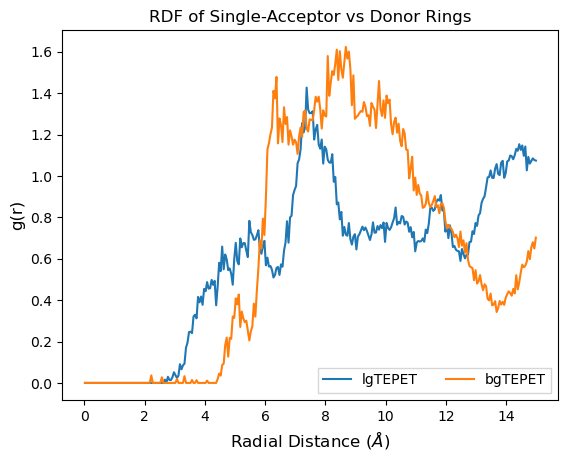

In [73]:
plt.plot(rdf_acceptordonor.results.bins, rdf_acceptordonor.results.rdf, label = 'lgTEPET')
plt.plot(rdf_acceptordonor2.results.bins, rdf_acceptordonor2.results.rdf, label = 'bgTEPET')

plt.title('RDF of Single-Acceptor vs Donor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='lower right', fancybox=False, shadow=False, ncol=2)

<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_13276/1623914288.py:14: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


' we expect the inverse of this well i just changed the data  '

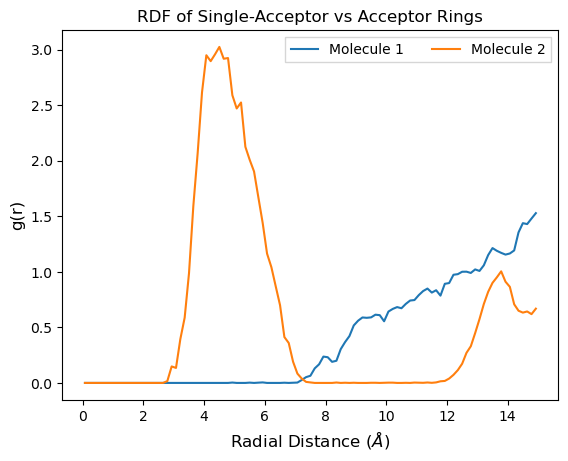

In [60]:
rdf_acceptoracceptor = InterRDF (acceptorsingle, acceptorexceptt, nbins = 300, range = (0.0, 15.0))
rdf_acceptoracceptor.run()
rdf_acceptoracceptor2 = InterRDF (acceptorsingle2, acceptorexceptt2, nbins = 300, range = (0.0,15.0))
rdf_acceptoracceptor2.run()

plt.plot(rdf_acceptoracceptor.results.bins, rdf_acceptoracceptor.results.rdf, label = 'Molecule 1')
plt.plot(rdf_acceptoracceptor2.results.bins, rdf_acceptoracceptor2.results.rdf, label = 'Molecule 2')




plt.title('RDF of Single-Acceptor vs Acceptor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='upper right', fancybox=False, shadow=False, ncol=2)


""" we expect the inverse of this well i just changed the data  """


In [61]:
rdf_donordonor = InterRDF (donoronlyy, donorexceptt, nbins = 300, range = (0.0, 15.0))
rdf_donordonor.run()
rdf_donordonor2 = InterRDF (donoronlyy2, donorexceptt2, nbins = 300, range = (0.0, 15.0))
rdf_donordonor2.run()

<>:6: SyntaxWarning: invalid escape sequence '\A'
<>:6: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_13276/1462028747.py:6: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


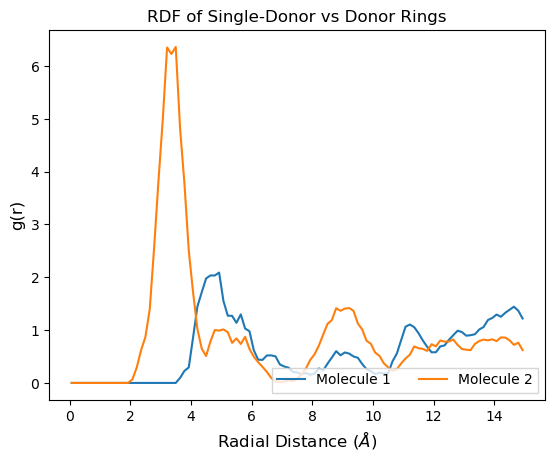

In [62]:
plt.plot(rdf_donordonor.results.bins, rdf_donordonor.results.rdf, label = 'Molecule 1')
plt.plot(rdf_donordonor2.results.bins, rdf_donordonor2.results.rdf, label = 'Molecule 2')

plt.title('RDF of Single-Donor vs Donor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='lower right', fancybox=False, shadow=False, ncol=2)

In [67]:
def rdf_rings(u, name):
    """
    Calculate the RDF of all rings in the universe and write it to a file
    
    Parameters:
    u : MDAnalysis Universe object
    name : str, filename for saving RDF data (will append .npy if needed)
    """
    # Ensure name is a string and has .npy extension
    if not isinstance(name, str):
        name = str(name)
    
    if not name.endswith('.npy'):
        name += '.npy'
    
    # Find all rings
    rings = find_all_rings(u)
    
    # Create RingGroup
    group = RingGroup(rings)
    
    # Calculate RDF
    rdf = InterRDF(g1=group, g2=group, 
                   range=(0, 15), 
                   nbins=105, 
                   start=-1500,
                   exclusion_block=(48, 48))  # exclude ring interactions
    
    try:
        # Run RDF calculation
        rdf.run()
        
        # Prepare RDF data
        rdf_saved = np.zeros((len(rdf.results.bins), 2))
        rdf_saved[:, 0] = rdf.results.bins
        rdf_saved[:, 1] = rdf.results.rdf
        np.save(name, rdf_saved)
        
        print(f"RDF data saved successfully to {name}")
        
    except Exception as e:
        print(f"Error calculating or saving RDF: {e}")
        # Optionally, generate a unique filename
        import uuid
        backup_name = f"rdf_rings_{uuid.uuid4().hex}.npy"
        np.save(backup_name, rdf_saved)
        print(f"Backup RDF data saved to {backup_name}")
    
    return rdf_saved

class RingGroup(object):
    def __init__(self, groups):
        self._groups = groups

    def __len__(self):
        return len(self._groups)

    @property
    def positions(self):
        return np.array([g.center_of_geometry() for g in self._groups], dtype=np.float32)

    @property
    def universe(self):
        return self._groups[0].universe
    



In [66]:
acceptor_only = mda.Universe('molecule1/ring universe/eum.pdb','molecule1/ring universe/eum.dcd', guess_bonds= True)
acceptor_only2 = mda.Universe('molecule2/ring universe/eum.pdb','molecule2/ring universe/eum.dcd', guess_bonds= True)

donor_only = mda.Universe('molecule1/ring universe/oth.pdb','molecule1/ring universe/oth.dcd', guess_bonds= True)
donor_only2 = mda.Universe('molecule2/ring universe/oth.pdb','molecule2/ring universe/oth.dcd', guess_bonds= True)

<>:21: SyntaxWarning: invalid escape sequence '\A'
<>:21: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_13276/3336883124.py:21: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


RDF data saved successfully to acceptor_acceptor.npy
RDF data saved successfully to acceptor_acceptor2.npy


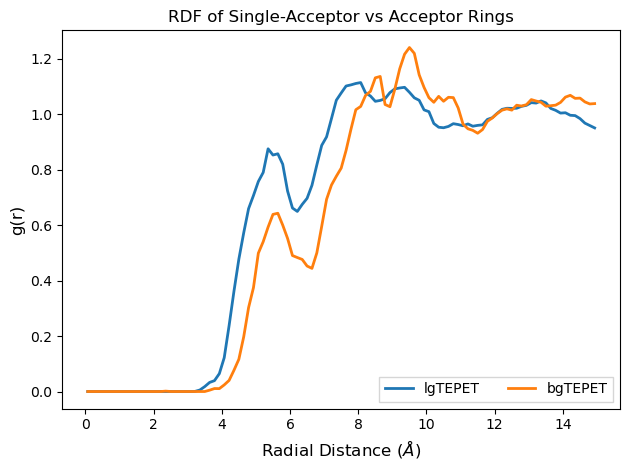

In [69]:
filename = 'acceptor_acceptor'
filename2 = 'acceptor_acceptor2'

rdf_rings(acceptor_only, name = filename)
rdf_rings(acceptor_only2, name = filename2)

rdf_data = np.load(filename + '.npy')
r = rdf_data[:, 0]
g_r = rdf_data[:, 1]

rdf_data2 = np.load(filename2 +'.npy')
r2 = rdf_data2[:, 0]
g_r2 = rdf_data2[:, 1]


# Create the plot
plt.plot(r, g_r, linewidth=2, label = 'lgTEPET')
plt.plot(r2, g_r2, linewidth=2, label = 'bgTEPET')
plt.title('RDF of Single-Acceptor vs Acceptor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='lower right', fancybox=False, shadow=False, ncol=2)
# Add some additional plot improvements
plt.tight_layout()


<>:21: SyntaxWarning: invalid escape sequence '\A'
<>:21: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_13276/1234028487.py:21: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


RDF data saved successfully to donor_donor.npy
RDF data saved successfully to donor_donor2.npy


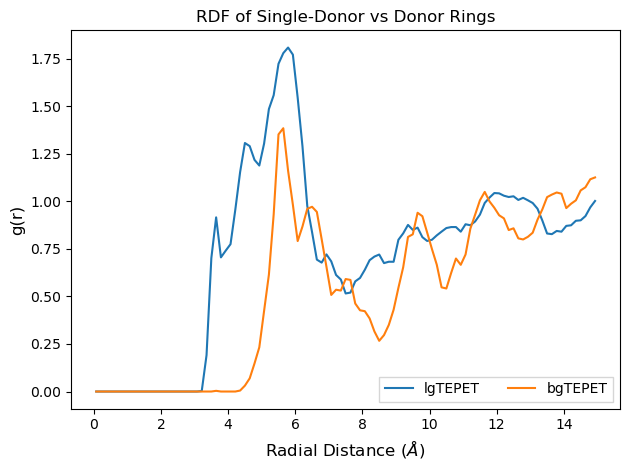

In [71]:
filename = 'donor_donor'
filename2 = 'donor_donor2'

rdf_rings(donor_only, name = filename)
rdf_rings(donor_only2, name = filename2)

rdf_data = np.load(filename + '.npy')
r = rdf_data[:, 0]
g_r = rdf_data[:, 1]

rdf_data2 = np.load(filename2 +'.npy')
r2 = rdf_data2[:, 0]
g_r2 = rdf_data2[:, 1]


# Create the plot
plt.plot(r, g_r, label = 'lgTEPET')
plt.plot(r2, g_r2, label = 'bgTEPET')
plt.title('RDF of Single-Donor vs Donor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='lower right', fancybox=False, shadow=False, ncol=2)
# Add some additional plot improvements
plt.tight_layout()


In [52]:
def rdf_rings(u, u2, name):
    """
    Calculate the RDF of all rings in the universe and write it to a file
    
    Parameters:
    u : MDAnalysis Universe object
    name : str, filename for saving RDF data (will append .npy if needed)
    """
    # Ensure name is a string and has .npy extension
    if not isinstance(name, str):
        name = str(name)
    
    if not name.endswith('.npy'):
        name += '.npy'
    
    # Find all rings
    rings = find_all_rings(u)
    rings2 = find_all_rings(u2)
    
    # Create RingGroup
    group = RingGroup(rings)
    group2 = RingGroup(rings2)
    
    # Calculate RDF
    rdf = InterRDF(g1=group, g2=group2, 
                   range=(0, 15), 
                   exclusion_block=(48,48)
                   )
      # exclude ring interactions
    
    try:
        # Run RDF calculation
        rdf.run()
        
        # Prepare RDF data
        rdf_saved = np.zeros((len(rdf.results.bins), 2))
        rdf_saved[:, 0] = rdf.results.bins
        rdf_saved[:, 1] = rdf.results.rdf
        np.save(name, rdf_saved)
        
        print(f"RDF data saved successfully to {name}")
        
    except Exception as e:
        print(f"Error calculating or saving RDF: {e}")
        # Optionally, generate a unique filename
        import uuid
        backup_name = f"rdf_rings_{uuid.uuid4().hex}.npy"
        np.save(backup_name, rdf_saved)
        print(f"Backup RDF data saved to {backup_name}")
    
    return rdf_saved

class RingGroup(object):
    def __init__(self, groups):
        self._groups = groups

    def __len__(self):
        return len(self._groups)

    @property
    def positions(self):
        return np.array([g.center_of_geometry() for g in self._groups], dtype=np.float32)

    @property
    def universe(self):
        return self._groups[0].universe
    



In [53]:

######################################################################
#Similarity metrics for networks
#https://en.wikipedia.org/wiki/Overlap_coefficient
#size of the intersection divided by the smaller of the 2 sets
#$$ overlap(X,Y) = \frac{| X \cap Y |}{min(|X|, |Y|)} $$

def overlap(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    overlap_with_0th = []
    for array in array_list:
        num = len(np.intersect1d(sorted(array_list[0]), sorted(array)))
        den = min(len(array_list[0]),len(array)) 
        overlap_with_0th.append(num/den)
    return overlap_with_0th

def overlap_traj(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    overlap_with_neighbors = []
    for i in range(len(array_list)-1):  # Adjusted range
        num = len(np.intersect1d(sorted(array_list[i+1]), sorted(array_list[i])))
        den = min(len(array_list[i+1]), len(array_list[i])) 
        overlap_with_neighbors.append(num/den)
    return overlap_with_neighbors

def overlap_matrix(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    nele = len(array_list)
    overlap = np.zeros((nele,nele))
    for i, j in itertools.combinations(range(nele),2):
        num = len(np.intersect1d(array_list[i], array_list[j]))
        den = min(len(array_list[i]),len(array_list[j])) 
        overlap[i,j] = num/den
        overlap[j,i] = num/den
    return overlap


In [379]:
def find_all_rings(u):
    # returns itic donor and acceptors rings
    # Handle atoms as Graph
    g = nx.Graph()
    g.add_edges_from(u.bonds.to_indices())
    # cycle_basis gives all rings
    cycles = nx.cycle_basis(g)
    # all atoms that are part of a ring
    ring_members = set(itertools.chain(*cycles))
    ring_ag = u.atoms[list(ring_members)]
    
    # Create graph to store rings
    g = nx.Graph()
    for cycle in cycles:
        for i in range(len(cycle)):
            # Add edges corresponding to the cycle
            g.add_edge(cycle[i], cycle[(i + 1) % len(cycle)])  # wraparound to form a cycle
            
    # Can then separate the connected parts of the graph
    chunks = list(nx.connected_components(g))
    
    # Locate donors as the biggest fused rings
    rings = [u.atoms[list(r)] for r in chunks if len(r) > 4]

    return rings

In [380]:
find_all_rings(u)
rdf_rings(u, name= 'test')

RDF data saved successfully to test.npy


array([[2.50000000e-02, 0.00000000e+00],
       [7.50000000e-02, 0.00000000e+00],
       [1.25000000e-01, 0.00000000e+00],
       [1.75000000e-01, 0.00000000e+00],
       [2.25000000e-01, 0.00000000e+00],
       [2.75000000e-01, 0.00000000e+00],
       [3.25000000e-01, 0.00000000e+00],
       [3.75000000e-01, 0.00000000e+00],
       [4.25000000e-01, 0.00000000e+00],
       [4.75000000e-01, 0.00000000e+00],
       [5.25000000e-01, 0.00000000e+00],
       [5.75000000e-01, 0.00000000e+00],
       [6.25000000e-01, 0.00000000e+00],
       [6.75000000e-01, 0.00000000e+00],
       [7.25000000e-01, 0.00000000e+00],
       [7.75000000e-01, 0.00000000e+00],
       [8.25000000e-01, 0.00000000e+00],
       [8.75000000e-01, 0.00000000e+00],
       [9.25000000e-01, 0.00000000e+00],
       [9.75000000e-01, 0.00000000e+00],
       [1.02500000e+00, 0.00000000e+00],
       [1.07500000e+00, 0.00000000e+00],
       [1.12500000e+00, 0.00000000e+00],
       [1.17500000e+00, 0.00000000e+00],
       [1.225000

In [381]:
array_list = np.load('test.npy')
arrays = overlap(array_list)
arrays

[1.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [337]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

def overlap(array_list):
    ''' Szymkiewicz–Simpson coefficient with first array'''
    overlap_with_0th = []
    for array in array_list:
        num = len(np.intersect1d(sorted(array_list[0]), sorted(array)))
        den = min(len(array_list[0]),len(array)) 
        overlap_with_0th.append(num/den)
    return overlap_with_0th

def overlap_traj(array_list):
    ''' Szymkiewicz–Simpson coefficient between consecutive arrays'''
    overlap_with_neighbors = []
    for i in range(len(array_list[:-1])):
        num = len(np.intersect1d(sorted(array_list[i+1]), sorted(array_list[i])))
        den = min(len(array_list[i+1]),len(array_list[i])) 
        overlap_with_neighbors.append(num/den)
    return overlap_with_neighbors

def overlap_matrix(array_list):
    ''' Szymkiewicz–Simpson coefficient matrix for all pairwise comparisons'''
    nele = len(array_list)
    overlap = np.zeros((nele, nele))
    for i, j in itertools.combinations(range(nele), 2):
        num = len(np.intersect1d(array_list[i], array_list[j]))
        den = min(len(array_list[i]), len(array_list[j])) 
        overlap[i, j] = num/den
        overlap[j, i] = num/den
    # Set diagonal to 1 (self-comparison)
    np.fill_diagonal(overlap, 1.0)
    return overlap



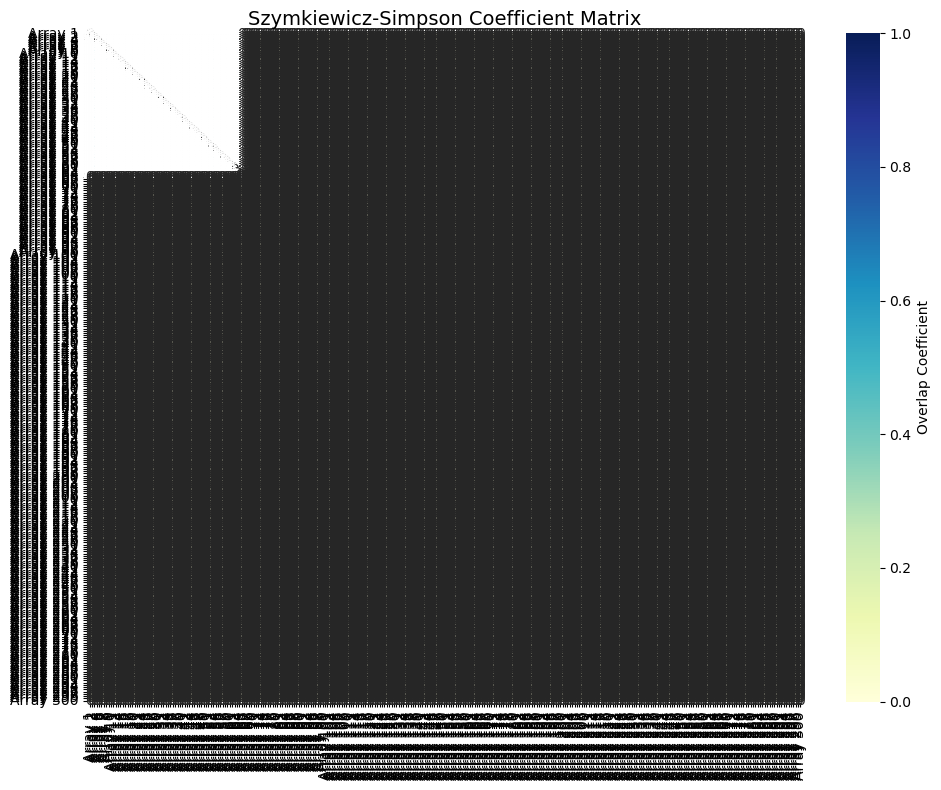

In [349]:
import numpy as np
import itertools

# Example: Overlap matrix function
def overlap_matrix(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    nele = len(array_list)
    overlap = np.zeros((nele, nele))

    for i, j in itertools.combinations(range(nele), 2):
        if isinstance(array_list[i], (list, np.ndarray)) and isinstance(array_list[j], (list, np.ndarray)):
            num = len(np.intersect1d(array_list[i], array_list[j]))
            den = min(len(array_list[i]), len(array_list[j]))
            overlap[i, j] = num / den
            overlap[j, i] = num / den
        else:
            print(f"Error: Non-iterable found in array_list at indices {i} and {j}")
            continue

    return overlap

# Ensure 'arrays' is a list of arrays
arrays = np.load('test.npy', allow_pickle=True)

# If arrays is a 2D numpy array, convert it to a list of arrays
if isinstance(arrays, np.ndarray) and arrays.ndim == 2:
    arrays = arrays.tolist()

# Calculate overlap matrix
overlap_mat = overlap_matrix(arrays)

# Proceed with plotting (same as your existing code)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 8))

# Create heatmap
ax = sns.heatmap(overlap_mat, annot=True, cmap="YlGnBu", vmin=0, vmax=1, 
                xticklabels=[f"Array {i+1}" for i in range(len(arrays))],
                yticklabels=[f"Array {i+1}" for i in range(len(arrays))])

plt.title("Szymkiewicz-Simpson Coefficient Matrix", fontsize=14)
plt.tight_layout()

# Add colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Overlap Coefficient')

plt.show()


In [382]:
######################################################################
#network analysis functions - micaela matta
######################################################################

import numpy as np
import networkx as nx
import itertools
import MDAnalysis as mda
from MDAnalysis.analysis import rdf
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import capped_distance
from MDAnalysis.lib.distances import calc_angles


# hyrogen bonds between donor and acceptor atoms
def hbonds(hyd, acc):
    don = []
    for H in hyd:
        O = H.bonded_atoms[0]
        don.append(O)
    don=sum(don)
    d = capped_distance(hyd.positions,
                        acc.positions,
                        max_cutoff=3,
                        box=hyd.dimensions,
                        return_distances=False)
    h_idx, a_idx = d.T
    hyd = hyd[h_idx]
    don = don[h_idx]
    acc = acc[a_idx]
    a = calc_angles(don.positions, hyd.positions, acc.positions, box=hyd.dimensions)
    a_crit = np.deg2rad(130)

    mask = []
    for i, ang in zip(range(len(acc)), a):
        if ang > a_crit:
            mask.append(i)
    don = don[mask]
    hyd = hyd[mask]
    acc = acc[mask]
    return hyd, don, acc

def resid_network(u):
# todo: remove hardcoding of atom types!
    netlist = []
    HYD = u.atoms.select_atoms("resname EUM")           # donor atom types
    ACC = u.atoms.select_atoms("resname OTH") # acceptor atom types  
    #find hydrogen bonds
    hyd, don, acc = hbonds(HYD, ACC)

    # use ce as a central node of the network
    ces = u.atoms.select_atoms('type ce cE')
    cfs = u.atoms.select_atoms('type cf cF')
    # move ce atom to the center of the ce-cf bond
    for e, f in zip(ces,cfs):
        e.position = (e+f).center_of_geometry()
    
    new_bonds = []     
    #create new bond between ce atoms of different residues, if there is a hb between them
    for d, a in zip(acc, don):
        don_e = d.residue.atoms.select_atoms('type ce cE')[0]
        acc_e = a.residue.atoms.select_atoms('type ce cE')[0]
        if don_e.residue!=acc_e.residue:
            new_bonds.extend([(don_e.ix, acc_e.ix)])

    # this modifies the universe connectivity
    u.add_bonds(new_bonds)
    # we cannot remove bonds from universe
    # when visualising the network we just select the atoms that are inside the network: ag_nets

    # network with only the ce-ce bonds
    g = nx.Graph()
    g.add_edges_from(new_bonds)

    # list of networks
    g_subs = list(g.subgraph(c) for c in nx.connected_components(g))

    # list of atom indices from which we can recreate atomgroups
    ag_nets=[u.atoms[n.nodes].ix for n in g_subs]


    return g_subs, ag_nets

def resid_network_fast(u):
#todo: remove hardcoding of atom types!
    netlist = []
    HYD = u.atoms.select_atoms("type ho hn")
    ACC = u.atoms.select_atoms("type oq oh o na n nq")
    #find hydrogen bonds
    hyd, don, acc = hbonds(HYD, ACC)

    # use ce as a central node of the network
    ces = u.atoms.select_atoms('type ce cE')
    cfs = u.atoms.select_atoms('type cf cF')
    # move ce atom to the center of the ce-cf bond
    for e, f in zip(ces,cfs):
        e.position = (e+f).center_of_geometry()
    
    new_bonds = []     
    #create new bond between ce atoms of different residues, if there is a hb between them
    for d, a in zip(acc, don):
        don_e = d.residue.atoms.select_atoms('type ce cE')[0]
        acc_e = a.residue.atoms.select_atoms('type ce cE')[0]
        if don_e.residue!=acc_e.residue:
            new_bonds.extend([(don_e.ix, acc_e.ix)])

    # this modifies the universe connectivity
    u.add_bonds(new_bonds)
    # we cannot remove bonds from universe
    # when visualising the network we just select the atoms that are inside the network: ag_nets

    # network with only the ce-ce bonds
    g = nx.Graph()
    g.add_edges_from(new_bonds)

    # list of networks
    g_subs = list(g.subgraph(c) for c in nx.connected_components(g))

    # list of atom indices from which we can recreate atomgroups
    ag_nets=[u.atoms[n.nodes].ix for n in g_subs]
    return g_subs, ag_nets

def find_res_nets(u):
    """find the largest network in each frame"""
    nets_traj = []
    res_traj = []
    for ts in u.trajectory:
        g_subs, ag_nets =resid_network(u)
        nets_traj.append(g_subs)
        res_traj.append(ag_nets)
    return nets_traj, res_traj

def write_largest_traj(nets_traj, res_traj):
    """write the largest network in each frame"""
    large_nets_traj = []
    large_res_traj = []
    for nets, res in zip(nets_traj, res_traj):
        largest_net = sorted(nets, key=len, reverse=True)[0]
        largest_res = sorted(res, key=len, reverse=True)[0]
        large_res_traj.append(largest_res)
        large_nets_traj.append(largest_net)
    return large_nets_traj, large_res_traj


######################################################################
#Similarity metrics for networks
#https://en.wikipedia.org/wiki/Overlap_coefficient
#size of the intersection divided by the smaller of the 2 sets
#$$ overlap(X,Y) = \frac{| X \cap Y |}{min(|X|, |Y|)} $$

def overlap(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    overlap_with_0th = []
    for array in array_list:
        num = len(np.intersect1d(sorted(array_list[0]), sorted(array)))
        den = min(len(array_list[0]),len(array)) 
        overlap_with_0th.append(num/den)
    return overlap_with_0th

def overlap_traj(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    overlap_with_neighbors = []
    for i in range(len(array_list[:-1])):
        num = len(np.intersect1d(sorted(array_list[i+1]), sorted(array_list[i])))
        den = min(len(array_list[i+1]),len(array_list[i])) 
        overlap_with_neighbors.append(num/den)
    return overlap_with_neighbors

def overlap_matrix(array_list):
    ''' Szymkiewicz–Simpson coefficient'''
    nele = len(array_list)
    overlap = np.zeros((nele,nele))
    for i, j in itertools.combinations(range(nele),2):
        num = len(np.intersect1d(array_list[i], array_list[j]))
        den = min(len(array_list[i]),len(array_list[j])) 
        overlap[i,j] = num/den
        overlap[j,i] = num/den
    return overlap

######################################################################
# plot λ_z^2, the z component of the gyration tensor for fast networks
#for each of the above networks, we calculate and plot the corresponding 
# gyration tensor component along z, to quantify the extension along the fiber axis.
# $$ R_G^2 = + \lambda_{x,G}^2 + \lambda_{z,G}^2 + \lambda_{z,G}^2 $$
#$$\lambda_{z}^2 = \lambda_{z,G}^2 / \lambda_{z,fiber}^2 $$#

def calc_lambda_z(u,nets_traj):
    '''calculates lambda_z^2, the  component of the gyration tensor'''
    lambda_z = []
    for f, ts in enumerate(u.trajectory):
        ag_net = u.atoms[nets_traj[f]]
        ag_net.positions -= ag_net.center_of_mass()
        ag_net.align_principal_axis(2, [0,0,1])

        S =np.zeros((3,3))
        for i,j  in itertools.product(range(3), repeat=2):
            S[i,j] = np.sum(ag_net.positions[:,i]*ag_net.positions[:,j])
        lambda_z.append((np.linalg.eigh(S)[0]/ag_net.n_atoms)[2])
    return lambda_z

def lambda_ref(u):
    lambda_z_ref = []
    for f, ts in enumerate(dhi.trajectory):
        ag_net = u.atoms # all of the atoms for ref
        ag_net.positions -= ag_net.center_of_mass()
        ag_net.align_principal_axis(2, [0,0,1])
        S =np.zeros((3,3))
        for i,j  in itertools.product(range(3), repeat=2):
            S[i,j] = np.sum(ag_net.positions[:,i]*ag_net.positions[:,j])
        lambda_z_ref.append((np.linalg.eigh(S)[0]/ag_net.n_atoms)[2])
    return lambda_z_ref


AttributeError: 'str' object has no attribute 'bonded_atoms'

<>:20: SyntaxWarning: invalid escape sequence '\A'
<>:20: SyntaxWarning: invalid escape sequence '\A'
/var/folders/nd/kh4yd30d10304m_81k6dg9c80000gn/T/ipykernel_62286/3665253.py:20: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)


RDF data saved successfully to acceptor_donor.npy
RDF data saved successfully to acceptor_donor2.npy


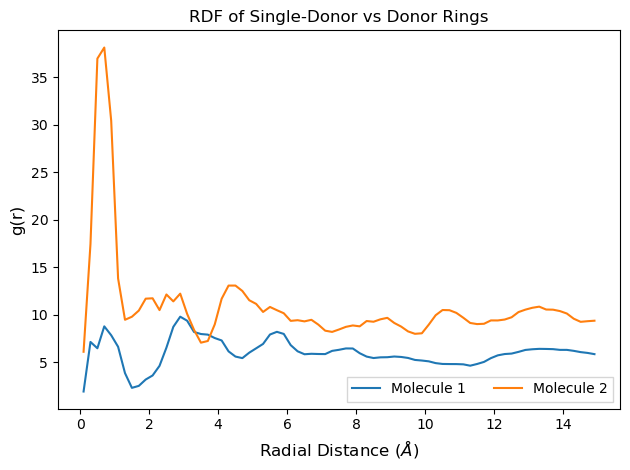

In [301]:
filename = 'acceptor_donor'
filename2 = 'acceptor_donor2'

rdf_rings(acceptor_only, donor_only, name = filename)
rdf_rings(acceptor_only2, donor_only2, name = filename2)

rdf_data = np.load(filename + '.npy')
r = rdf_data[:, 0]
g_r = rdf_data[:, 1]

rdf_data2 = np.load(filename2 +'.npy')
r2 = rdf_data2[:, 0]
g_r2 = rdf_data2[:, 1]

# Create the plot
plt.plot(r, g_r, label = 'Molecule 1')
plt.plot(r2, g_r2, label = 'Molecule 2')
plt.title('RDF of Single-Donor vs Donor Rings')
plt.grid(False)
plt.xlabel('Radial Distance ($\AA$)', fontsize = 12)
plt.ylabel('g(r)', fontsize = 12)
plt.legend(loc='lower right', fancybox=False, shadow=False, ncol=2)
# Add some additional plot improvements
plt.tight_layout()


In [305]:
def rdf_rings_intermolecular(u, name):
    """
    Calculate the RDF of rings between different molecules (excluding intramolecular ring interactions)
    
    Parameters:
    u : MDAnalysis Universe object
    name : str, filename for saving RDF data (will append .npy if needed)
    """
    # Ensure name has .npy extension
    if not isinstance(name, str):
        name = str(name)
    
    if not name.endswith('.npy'):
        name += '.npy'
    
    # Find all rings and separate by type
    all_rings = find_all_rings(u)
    
    # Identify which molecule each ring belongs to
    # This assumes you have a way to identify molecules (e.g., through residue IDs)
    molecule_ids = [ring.residues[0].resid for ring in all_rings]  # Adjust based on your data structure
    
    # Separate rings by type
    donor_rings = [ring for ring in all_rings if is_donor_ring(ring)]  # You'll need to define this function
    acceptor_rings = [ring for ring in all_rings if is_acceptor_ring(ring)]  # You'll need to define this function
    
    # Create RingGroups
    donor_group = RingGroup(donor_rings)
    acceptor_group = RingGroup(acceptor_rings)
    
    # Calculate RDF with customized exclusion function
    rdf = InterRDF(
        g1=donor_group, 
        g2=acceptor_group,
        range=(0, 15),
        exclusion_mask=generate_exclusion_mask(donor_rings, acceptor_rings, molecule_ids)
    )
    
    try:
        # Run RDF calculation
        rdf.run()
        
        # Prepare RDF data
        rdf_saved = np.zeros((len(rdf.results.bins), 2))
        rdf_saved[:, 0] = rdf.results.bins
        rdf_saved[:, 1] = rdf.results.rdf
        np.save(name, rdf_saved)
        
        print(f"RDF data saved successfully to {name}")
        
    except Exception as e:
        print(f"Error calculating or saving RDF: {e}")
        # Generate a unique filename for backup
        import uuid
        backup_name = f"rdf_rings_{uuid.uuid4().hex}.npy"
        try:
            np.save(backup_name, rdf_saved)
            print(f"Backup RDF data saved to {backup_name}")
        except:
            print("Could not save backup data")
    
    return rdf_saved

def generate_exclusion_mask(rings1, rings2, molecule_ids):
    """
    Generate a mask that excludes pairs of rings that belong to the same molecule
    
    Parameters:
    rings1, rings2 : lists of rings
    molecule_ids : list of molecule IDs for each ring
    
    Returns:
    mask : 2D boolean array where True indicates pairs to exclude
    """
    n1, n2 = len(rings1), len(rings2)
    mask = np.zeros((n1, n2), dtype=bool)
    all_rings = find_all_rings(u)
    # Map each ring to its molecule ID
    ring1_mol_ids = [molecule_ids[all_rings.index(ring)] for ring in rings1]
    ring2_mol_ids = [molecule_ids[all_rings.index(ring)] for ring in rings2]
    
    # Set mask to True for rings in the same molecule
    for i in range(n1):
        for j in range(n2):
            if ring1_mol_ids[i] == ring2_mol_ids[j]:
                mask[i, j] = True
    
    return mask

def is_donor_ring(ring):
    """
    Determine if a ring is a donor ring based on its properties
    Implement based on your specific molecular criteria
    """
    # Example implementation - replace with your actual logic
    # This could check for specific atoms, functional groups, etc.
    return True  # Placeholder

def is_acceptor_ring(ring):
    """
    Determine if a ring is an acceptor ring based on its properties
    Implement based on your specific molecular criteria
    """
    # Example implementation - replace with your actual logic
    return True  # Placeholder